# Computer Vision Project

Student : Riccardo Paolini

Project : Visual Inspection of Connecting Rods

In this project I wanted to write most of the functions related to Computer Vision by myself. 
I know that the program will be slower than those using extremely optimized functions, but I think that this
approach really helped me to better understand the theoretical part of the course.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math

pi = math.pi

# Kernels for Morphological Operators
cross5 = cv2.getStructuringElement(cv2.MORPH_CROSS,(5,5))
cross3 = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
square5 = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
square3 = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))

### Upload the image

There are many types of images in the folder, some of them with a lot of dust, some with touching objects and other with different types of objects. Try them all!

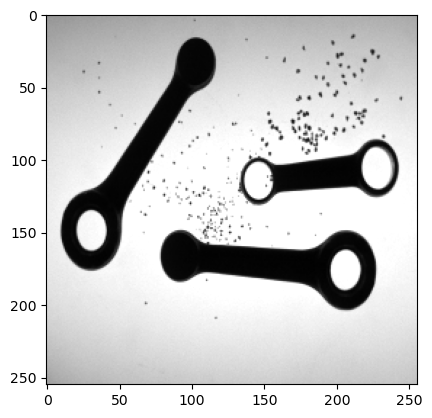

In [2]:
path = "rods_images/TESI92.BMP"

image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

plt.imshow(image, cmap='gray')
plt.show()

### Image Binarization - Otsu's Threshold

Otsu's method is a **variance-based technique** to find the **threshold value** where the weighted **variance between the foreground and background pixels is the least**. The key idea here is to iterate through all the possible values of threshold and measure the spread of background and foreground pixels.

In [3]:
# RETURNS: the optimal threshold according to OTSU's algorithm
def otsu(im): 
    
    # Instantiating the vector for the gray levels
    h = np.zeros((256,))
    
    # Create the Histogram of gray levels
    for l in range(256):
        h[l] = np.sum(im == l)
    
    # Probability of each gray level
    p = h/np.sum(h)
    
    # Create the Withing-group Variance list
    wgv = []
    
    # For each possible Threshold we compute the mean and the std of the two groups
    for T in range(256):
        
        # if we have 0 samples for one of the two groups we skip to the next THRESHOLD
        if np.sum(h[:T+1]) > 0 and np.sum(h[T+1:]) > 0:
            
            # Initialization of the mean and the standard deviation
            mu1, mu2 = 0, 0
            std1, std2 = 0, 0
            
            # Evaluation of the MEAN
            for l in range(256):
                if l <= T:
                    mu1 += l * p[l] / np.sum(h[:T+1])
                else:
                    mu2 += l * p[l] / np.sum(h[T+1:])
            
            # Evaluation of the STANDARD DEVIATION
            for l in range(256):
                if l <= T:
                    std1 += ((l - mu1)**2) * p[l] / np.sum(h[:T+1])
                else:
                    std2 += ((l - mu2)**2) * p[l] / np.sum(h[T+1:])
            
            # Appending the WITHIN-GROUP VARIANCE to the list
            wgv.append(std1 * np.sum(h[:T+1]) + std2 * np.sum(h[T+1:]))
        else:
            # Appending an INFINITE value to the list in case we have 0 samples for one of the two groups
            wgv.append(float('inf'))
    
    return np.argmin(wgv)

Image binarization is the process of taking a grayscale image and **converting it to black-and-white**, essentially reducing the information contained within the image from 256 shades of gray to 2: black and white (**binary image**). To binarize the image we need to apply some thresholding method. In this case we applied the **Otsu's threshold** defined above.

In [4]:
# Selection of the Otsu's threshold
T = otsu(image)

# Image Binarization
im_bin_noise = 255-((image > T) * 255).astype('uint8')

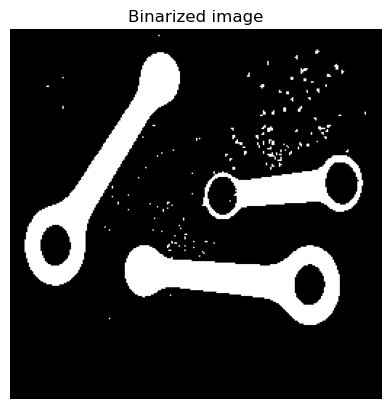

In [5]:
# Visulization of the Binarized image
plt.imshow(im_bin_noise, cmap='gray')
plt.title('Binarized image')
plt.axis('off')
plt.show()

### Remove the Noise due to dust and dirt

Now that we have the binary image we want to **remove the impurities** in it, such as dust and dirt. To do that we have applied **median filtering** which removes the smallest impurities and then we removed the others by using some **morphological operator**.

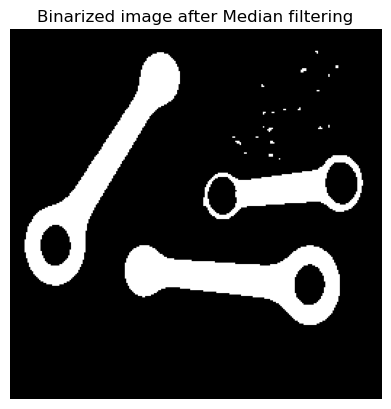

In [6]:
# Remove some noise through Median filtering
im_blur = cv2.medianBlur(im_bin_noise, 3)

plt.imshow(im_blur, cmap='gray')
plt.title('Binarized image after Median filtering')
plt.axis('off')
plt.show()

In [7]:
# Dilation (to keep thin borders safe from Opening) -> Opening -> 2x Dilation -> 2x Erosion
dilation1 = cv2.dilate(im_blur, square3, iterations = 1)
opening = cv2.morphologyEx(dilation1, cv2.MORPH_OPEN, cross5)
dilation2 = cv2.dilate(opening, square3, iterations = 2)
erosion = cv2.erode(dilation2, square3, iterations = 2)

# Other 2 steps of median filtering to remove residual noise
mask = cv2.medianBlur(cv2.medianBlur(cv2.bitwise_and(im_bin_noise, erosion), 3), 3)

# The final binarized image is obtained from the original image and the related mask
im_bin = cv2.bitwise_and(mask, im_bin_noise)

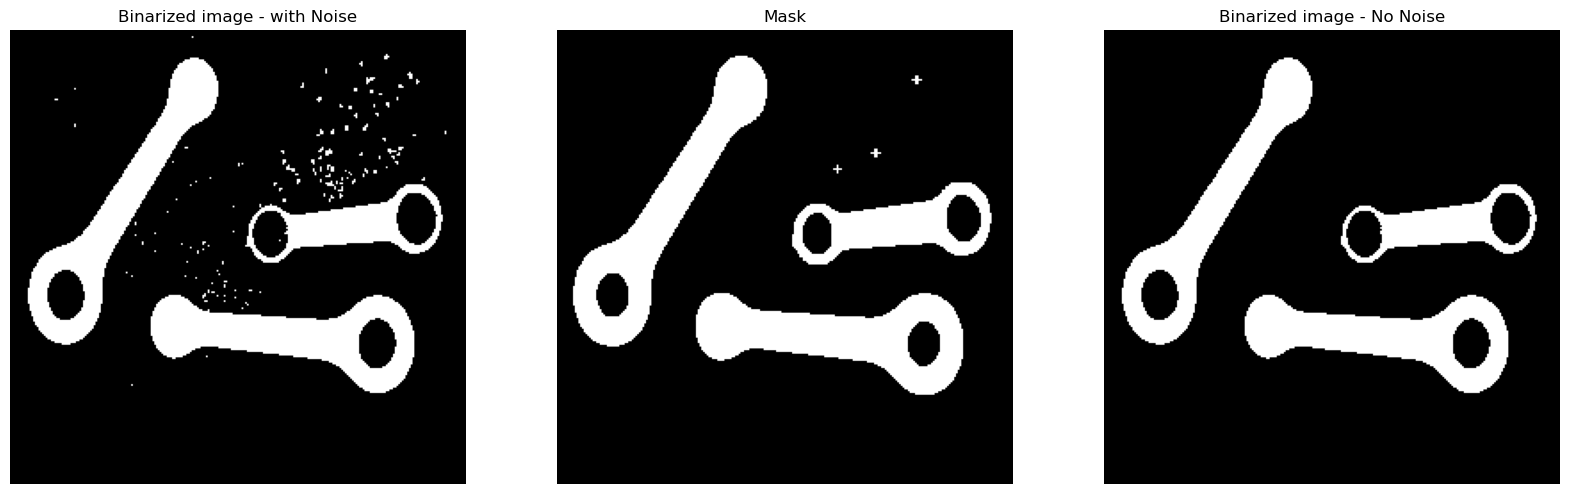

In [8]:
plt.figure(figsize=(20,10))

plt.subplot(1,3,1)
plt.imshow(im_bin_noise, cmap='gray')
plt.title('Binarized image - with Noise')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(erosion, cmap='gray')
plt.title('Mask')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(im_bin, cmap='gray')
plt.title('Binarized image - No Noise')
plt.axis('off')
plt.show()

### Saparation of touching objects (find corners and draw a line)

In this task we want to classify single objects, so we want to **separate the touching ones**, otherwise we cannot create the masks needed to consider them independently. To do so, we have to **look for corners** (that creates when two objects are touching) and **draw separation lines** between the objects.

First we flood-fill the image to prevent internal erosion.

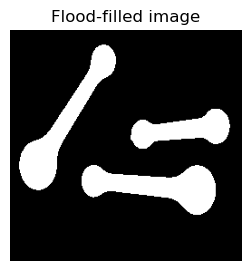

In [9]:
# Flood-filling
th, im_th = cv2.threshold(im_bin, 220, 255, cv2.THRESH_BINARY);
im_floodfill = im_th.copy()
h, w = im_th.shape[:2]
mask_filling = np.zeros((h+2, w+2), np.uint8)
cv2.floodFill(im_floodfill, mask_filling, (0,0), 255);
im_floodfill_inv = cv2.bitwise_not(im_floodfill)
im_out = im_th | im_floodfill_inv

plt.figure(figsize=(3,3))
plt.imshow(im_out, cmap='gray')
plt.title('Flood-filled image')
plt.axis('off')
plt.show()

Then we apply the **Harris' corner detector** to find corners and locate them in the image.

In [10]:
# Find Corners
harris = cv2.cornerHarris(im_out,2,5,0.04)
corners = np.where(((harris>1)*255).astype('uint8') == True)

# Find Centroids of touching corners
_, _, _, centroids = cv2.connectedComponentsWithStats(((harris>1)*255).astype('uint8'), 8, cv2.CV_32S)

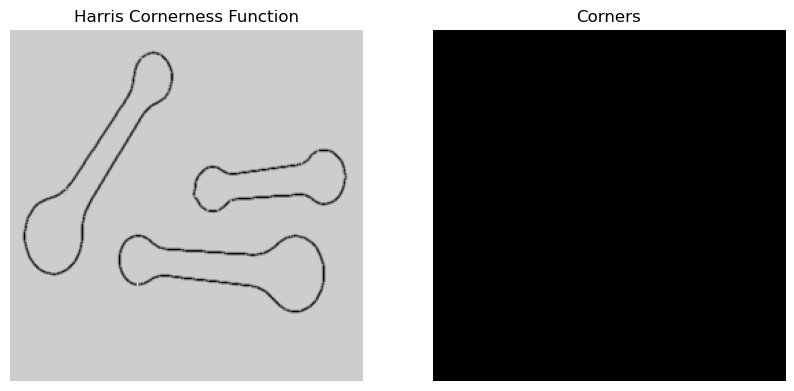

In [11]:
# Show corners in the image
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(harris, cmap='gray')
plt.title("Harris Cornerness Function")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(((harris>1)*255).astype('uint8'), cmap='gray')
plt.title("Corners")
plt.axis('off')
plt.show()

At this point we have to deal with **clusters of corners**. In fact, when we apply Harris' detector we find multiple corners in a small area surrounding a corner. So, we have decided to **group them together in a centroid** that represents their average position.

In [12]:
# Coordinates of Centroids
coor_tuples = [tuple(l) for l in centroids[1:]]

# Minimum distance between centroids (two centroids at 3/4 pixels of distance are considered as one single centroid)
thresh = 10

def distance(pt1, pt2):
    (x1, y1), (x2, y2) = pt1, pt2
    dist = math.sqrt( (x2 - x1)**2 + (y2 - y1)**2 )
    return dist

coor_tuples_copy = coor_tuples

# Keep only centroids with a distance to the others > thresh (Discarding really close centroids)
i = 1    
for pt1 in coor_tuples:
    for pt2 in coor_tuples[i::1]:
        if(distance(pt1, pt2) < thresh):
            coor_tuples_copy.remove(pt2)      
    i+=1
    
print(coor_tuples_copy)

[]


The next step consist in **finding all the possible pairs of centroids** and select the closest pairs to draw the **separation lines**.

In [13]:
# Store the conjunctions (We will cut the object by drawing a line between those coordinates) 
conjunctions = []

if len(coor_tuples_copy)//2 > 0:
    # Find all the Conjunctions between pairs of near Centroids
    for i in range(len(coor_tuples_copy)):
        dist = 999
        for j in range(len(coor_tuples_copy)):
            if i != j:
                d = distance(coor_tuples_copy[i], coor_tuples_copy[j])
                if d < dist and d > 10: 
                    dist = d
                    m = i
                    n = j
        if (coor_tuples_copy[n], coor_tuples_copy[m]) not in conjunctions:
            conjunctions.append((coor_tuples_copy[m], coor_tuples_copy[n]))
    
print(conjunctions)

[]


Now let's draw the lines...

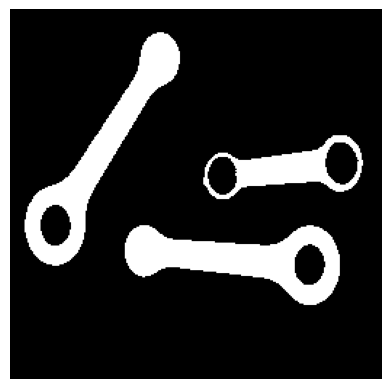

In [14]:
# Rounding the coordinates
round_conj = [(round(el[0]), round(el[1])) for c in conjunctions for el in c]

im_sep = np.copy(im_bin)

# Draw separation lines
for i in range(0, len(round_conj), 2):
    im_sep = cv2.line(im_out, round_conj[i], round_conj[i+1], color=[0,0,0], thickness=1)
    
plt.imshow(im_sep, cmap='gray')
plt.axis('off')
plt.show()

### Define the Scan Algorithm with immediate label update

As we mentioned before we must consider the objects indepentently. To this end, we **attach a label** to each of them. To do this we use a **scan algorithm**.

In [15]:
# Changes the label 'l2' with the label 'l1'
# RETURNS: the updated image
def update(im, l1, l2):
    im[im == l2] = l1
    return im

# Assign a label to each object
# RETURNS: the labeled image 
def scan(im):

    # Background
    B = 0
    # Foreground
    F = 255
    # Label
    L = 0

    im1 = np.zeros(im.shape, dtype='uint8')
    
    for r in range(1, im.shape[0]):
        for c in range(1, im.shape[1]):
            if im[r,c] == F:
                
                # If the pixel above and the one at the left have different labels -> Unify the labels (Update function)
                if im[r,c-1] == F and im[r-1,c] == F and im1[r,c-1] != im1[r-1,c]:
                    im1[r,c] = im1[r,c-1]
                    im1 = update(im1, im1[r-1,c], im1[r,c-1])
                    
                # If only the pixel at the left has a label -> Assign that label to the current one 
                elif im[r,c-1] == F:
                    im1[r,c] = im1[r,c-1]
                    
                # If only the pixel above has a label -> Assign that label to the current one     
                elif im[r-1,c] == F:
                    im1[r,c] = im1[r-1,c]
                    
                # Assign a new label    
                else:
                    L += 1
                    im1[r,c] = L
    return im1

Now that we have defined it, we create the labeled image.

In [16]:
# Labeling the objects
labeled = scan(im_sep)

# Store the labels (excluding the first (Background))
labels = np.unique(labeled)[1:]

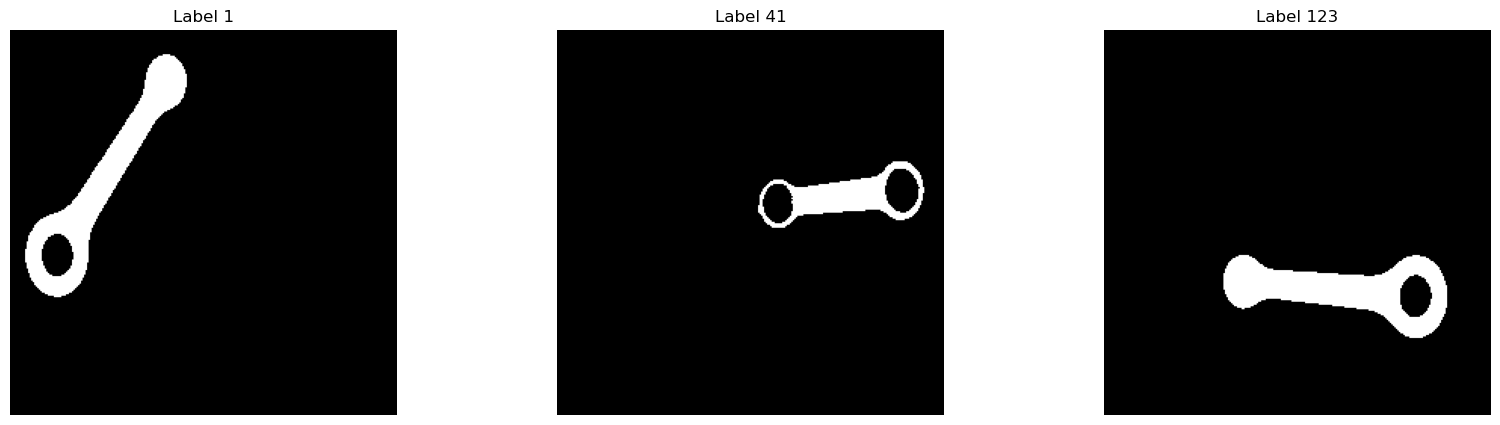

In [17]:
# Show the separated objects
plt.figure(figsize=(20,5))
for idx, l in enumerate(labels):
    plt.subplot(1,len(labels), idx+1)
    plt.imshow((labeled == l)*255, cmap='gray')
    plt.title(f'Label {l}')
    plt.axis('off')
plt.show()

## Plotting the detected objects

In this section we are seeking to keep only the rods. To do so, we will discard the objects with very small area (residual noise) and the objects without any hole (not rods).

Keep objects with an area grater than 50 pixels.

In [18]:
# Saving the Objects with area greater than 50
objects = []

idx = 0
for lab in labels:
    
    # Check on the Area
    if np.sum(labeled == lab) > 50:
        
        idx += 1
        obj = ((labeled == lab)*255).astype('uint8')
        
        # Dilate a little bit the object to recover some possible problem due to lines drawing
        dilated = cv2.dilate(obj, square3, iterations = 2)
        
        # the Object is obtain by the superposition of the Filled, Separated and Dilated version of the image without noise
        # and the image without noise itself
        obj = cv2.medianBlur(cv2.bitwise_and(dilated, im_bin), 3)
        
        # Storing the separated objects
        objects.append(obj)

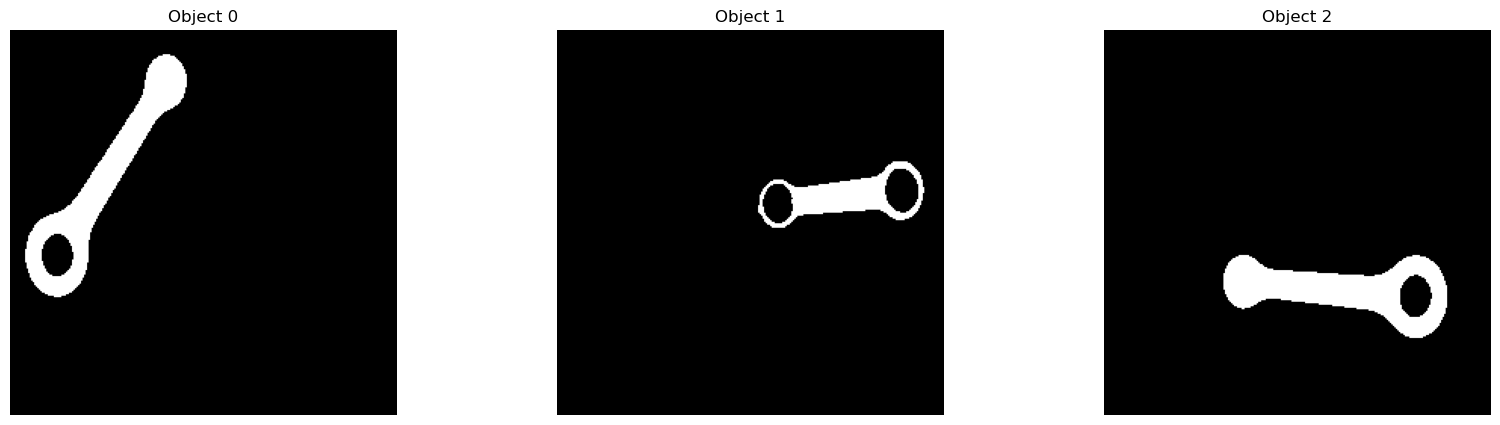

In [19]:
# Show retained objects
plt.figure(figsize=(20,5))

for idx, obj in enumerate(objects):
    plt.subplot(1,len(objects), idx+1)
    plt.imshow(obj, cmap='gray')
    plt.title("Object " + str(idx))
    plt.axis('off')  
    
plt.show()

Keep objects with at least one hole.

In [20]:
# Saving the Objects with holes
obj_with_holes = []

idx = 0
for obj in objects:
    
    # Counting the number of holes
    holes = scan(255-obj)
    n_holes = len(np.unique(holes))-1     # the -1 is needed to eliminate the count of the background
    
    # Check the n° of holes
    if n_holes > 0:
        idx += 1

        # Append if the object has at least one hole
        obj_with_holes.append(obj)    

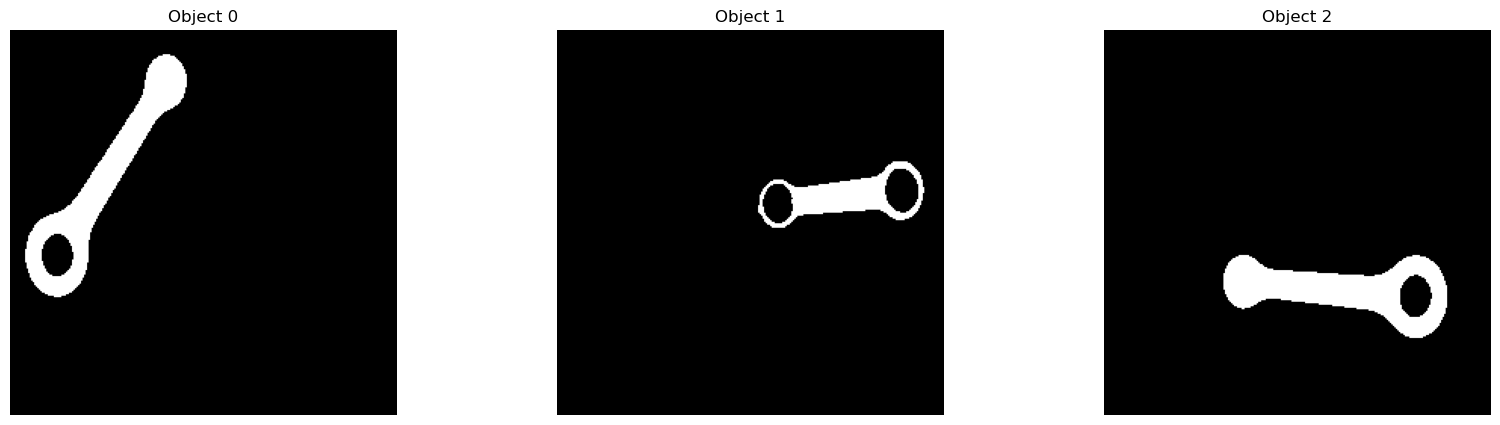

In [21]:
# Show retained objects
plt.figure(figsize=(20,5))

for idx, obj in enumerate(obj_with_holes):
    plt.subplot(1,len(obj_with_holes), idx+1)
    plt.imshow(obj, cmap='gray')
    plt.title("Object " + str(idx))
    plt.axis('off')  
    
plt.show()

### Define the Barycenter

In [22]:
# RETURNS: the position of the Barycenter (i, j) 
def barycenter(im):
    
    # Area
    A = np.sum(im==255)
    
    # Vectors for Matrix products
    v_i = np.array(list(range(im.shape[0])))
    v_j = np.transpose(list(range(im.shape[1])))
       
    # Matrix products to get the coordinates
    i = (np.sum(np.dot(v_i, (im==255)))/A).astype('uint8')
    j = (np.sum(np.dot((im==255), v_j))/A).astype('uint8')
    
    return i, j

### Define the Central Moments

In [23]:
# RETURNS: the value of the Moment of order (m, n)
def central_moment(im, m, n):
    
    # Moment
    M = 0
    # Barycenter
    B = barycenter(im)
    
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            if im[i,j] == 255:
                M += (i - B[0])**m * (j - B[1])**n
    return M

### Define the line drawing function

In [24]:
# RETURNS: the coordinates to plot the lines with the function cv2.line()
def line(theta, centre, shape):
    i_start, i_end = 0, 0
    j_start, j_end = 0, 0
           
    
    if (theta*180/math.pi < 45) or (135 < theta*180/math.pi < 225) or (315 < theta*180/math.pi):
        i_start, i_end = 0, 0
        j_start, j_end = 0, 0
        for i in range(shape[0]):
            j = np.tan(theta)*(i-centre[0]) + centre[1]
            if 0 < j < shape[1]:
                if j_start == 0 and i_start == 0:
                    j_start = j.astype('uint8')
                    i_start = i

                j_end = j.astype('uint8')
                i_end = i 
    else:
        for j in range(shape[1]):
            i = (1/np.tan(theta))*(j-centre[1]) + centre[0]
            if 0 < i < shape[0]:
                if j_start == 0 and i_start == 0:
                    j_start = j
                    i_start = i.astype('uint8')

                j_end = j
                i_end = i.astype('uint8')
    
    return (j_start, i_start), (j_end, i_end)

### Pose of the Objects

The pose of an object is the combination of the object's position and orientation. To get the pose of the object we have to evaluate its barycenter and moments.

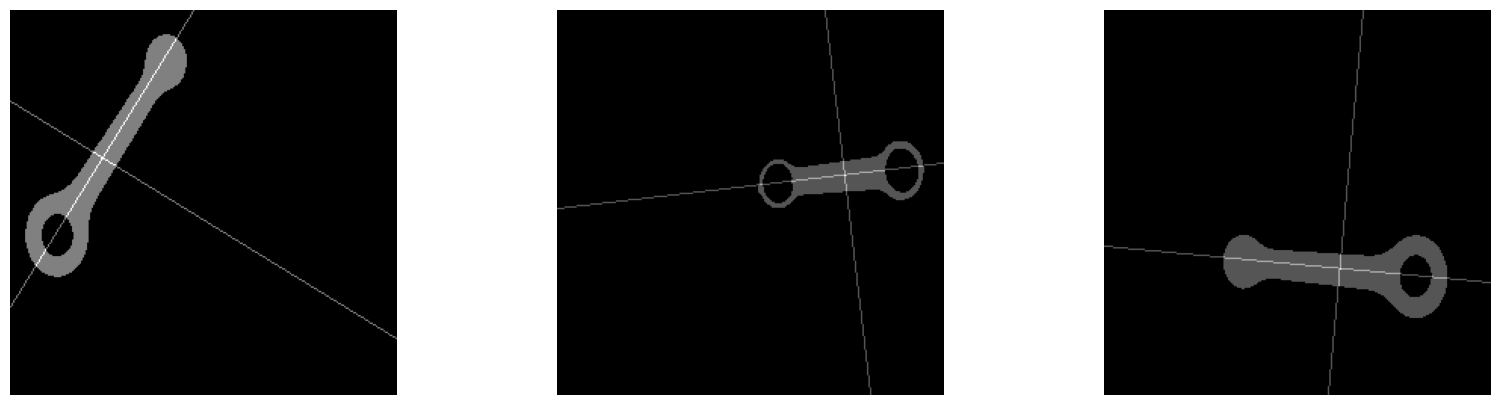

In [25]:
# Save (θ, Barycenter, major axis, minor axis) of the considered objects 
params = []

plt.figure(figsize=(20,5))

for idx, obj in enumerate(obj_with_holes):
    
    # Area & Barycenter of the object
    A = central_moment(obj, 0, 0)
    B = barycenter(obj)
    
    # Evaluation of θ
    theta = -0.5 * np.arctan((2 * central_moment(obj, 1, 1)) / (central_moment(obj, 0, 2) - central_moment(obj, 2, 0)))

    # Adjustment of theta (when M_02 > M_20 the axes are inverted...)
    if central_moment(obj, 0, 2) > central_moment(obj, 2, 0):
        theta = theta+pi/2
    
    # Major axis
    startP, endP = line(theta, B, obj.shape)
    major = cv2.line(np.zeros(obj.shape), startP, endP, color=(255,255,255), thickness=1)
    
    # Minor axis
    startP, endP = line(theta+pi/2, B, obj.shape)
    minor = cv2.line(np.zeros(obj.shape), startP, endP, color=(255,255,255), thickness=1)
    
    # Appending parameters
    params.append((theta, B, major, minor))
    
    plt.subplot(1, len(obj_with_holes), idx+1)
    plt.imshow(major+minor+obj, cmap='gray')
    plt.axis('off')

plt.show()

### Define the Bounding Box

In this function we have also **included the evaluation of the dimensions** of the object such as the **Length, Width and Width at the barycenter**.

In [26]:
# RETURNS: the Minimum Enclosing Rectangle, Length, Width and Width at the barycenter of the object
def boundingBox(contour, params):
    theta = params[0]
    i, j = params[1]
    shape = contour.shape
    
    box = np.zeros(shape, dtype='uint8')
    
    D = []
    
    # All this block below perform and Exponential search
    # It finds the distance between the barycenter and the furthest points in the four directions (along the major/minor axis)
    if (theta*180/pi < 45) or (135 < theta*180/pi < 225) or (315 < theta*180/pi):
          
        # Right -> Left -> Up -> Down
        for d in [(0, 1), (0, -1), (-1, 0), (1, 0)]:
            
            # Actual step, low bound, high bound 
            s = 1
            low = 1
            high = 1
            
            while True:
                
                start, end = line(theta+abs(d[0])*math.pi/2, (i+s*d[0], j+s*d[1]), shape)
                
                border = (cv2.line(np.zeros(shape), start, end, color=(255,255,255), thickness=1)).astype('uint8')
                
                if np.sum(np.bitwise_and(border, contour)) > 0:
                    if abs(s-low) == 1 and s != high:
                        box = (cv2.line(box, start, end, color=(255,255,255), thickness=1)).astype('uint8')
                        break
                        
                    low = s
                    if s == high:
                        s = s*2
                        high = s
                    elif s < high:
                        s = (low+high)/2
                else:
                    if abs(s-low) == 1 and s != high:
                        s = low
                        start, end = line(theta+abs(d[0])*math.pi/2, (i+s*d[0], j+s*d[1]), shape)
                        box = (cv2.line(box, start, end, color=(255,255,255), thickness=1)).astype('uint8')
                        break
                        
                    high = s   
                    s = (low+high)/2
            
            # Here we have the Lateral Translation (i) needed to reach the border
            # From 'i' we can evaluate the distance from the center to the border
            D.append(s*np.cos(theta))
    
    else:
         
        # Right -> Left -> Up -> Down
        for d in [(0, 1), (0, -1), (-1, 0), (1, 0)]:
            
            # Actual step, low bound, high bound 
            s = 1
            low = 1
            high = 1
            
            while True:
                
                start, end = line(theta+abs(d[1])*pi/2, (i+s*d[0], j+s*d[1]), shape)
                
                border = (cv2.line(np.zeros(shape), start, end, color=(255,255,255), thickness=1)).astype('uint8')
                
                if np.sum(np.bitwise_and(border, contour)) > 0:
                    if abs(s-low) == 1 and s != high:
                        box = (cv2.line(box, start, end, color=(255,255,255), thickness=1)).astype('uint8')
                        break
                        
                    low = s
                    if s == high:
                        s = s*2
                        high = s
                    elif s < high:
                        s = (low+high)/2
                else:
                    if abs(s-low) == 1 and s != high:
                        s = low
                        start, end = line(theta+abs(d[1])*pi/2, (i+s*d[0], j+s*d[1]), shape)
                        box = (cv2.line(box, start, end, color=(255,255,255), thickness=1)).astype('uint8')
                        break
                        
                    high = s   
                    s = (low+high)/2
            
            # Here we have the Lateral Translation (i) needed to reach the border 
            # From 'i' we can evaluate the distance from the center to the border
            D.append(s*np.sin(theta))
    
    # Evaluation of the Width at the Baricentre
    start, end = line(theta+pi/2, (i, j), shape)            
    border = (cv2.line(np.zeros(shape), start, end, color=(255,255,255), thickness=1)).astype('uint8')
    
    # Points where the minor axis intersects the contour
    points = np.nonzero(np.bitwise_and(border, contour))   
    
    # Euclidean distance between the two points
    width_bar = np.sqrt((points[0][0]-points[0][1])**2 + (points[1][0]-points[1][1])**2)
    
    # If there are more than two points -> take the maximum distance between the pairs 
    if len(points[0]) > 2:
        # Euclidean distance between the two points
        width_bar = np.sqrt((points[0][0]-points[0][-1])**2 + (points[1][0]-points[1][-1])**2)  
    
    # Returning Length and Width in the right order
    if np.sum(np.absolute(D[:2])) > np.sum(np.absolute(D[2:])):
        return box, np.sum(np.absolute(D[:2])), np.sum(np.absolute(D[2:])), width_bar
    else:
        return box, np.sum(np.absolute(D[2:])), np.sum(np.absolute(D[:2])), width_bar

### Keep elongated objects

Objects that are not elongated like washers must be deleted. So, we keep only objects with an elongation ration greater than 2.

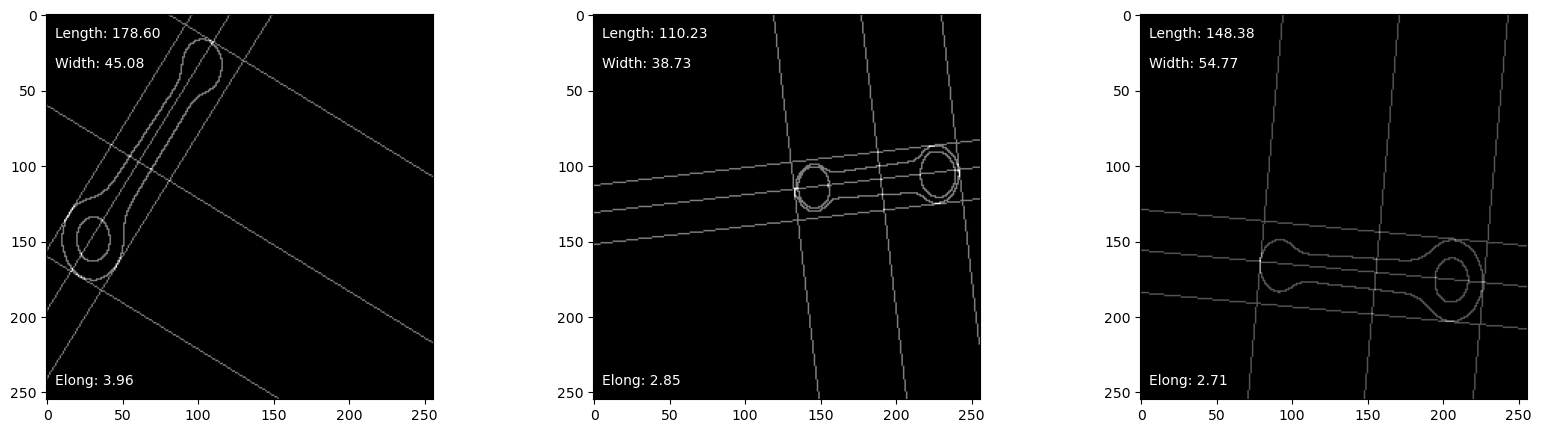

In [27]:
# Save the elongated objects and their parameters
elongated_objects = []
elongated_params = []

plt.figure(figsize=(20,5))

for idx, obj in enumerate(obj_with_holes):
    
    # Retrieve the major and minor axes of the object
    major, minor = params[idx][2:]
    
    # Obtain the inner contour through subtraction between the object and its eroded version
    erosion = cv2.erode(obj.astype('uint8'),square3,iterations = 1)
    contour = obj - erosion
    
    # Evaluation of MER, Length, Width, Width at the barycenter
    box, L, W, Wb = boundingBox(contour, params[idx])
    
    plt.subplot(1, len(obj_with_holes), idx+1)
    plt.imshow(major+minor+contour+box, cmap='gray')
    plt.text(5,15, f"Length: {L:.2f}", c="white")
    plt.text(5,35, f"Width: {W:.2f}", c="white")
    plt.text(5,obj.shape[0]-10, f"Elong: {L/W:.2f}", c="white")
    
    # Checking the Elongation of the object (Eliminated if the ratio is < 2)
    if L/W > 2:
        elongated_objects.append(obj)
        elongated_params.append((box, L, W, Wb, params[idx]))
    
plt.show()

In [28]:
# Transform all the pixels > 0 in 255 (only for visualization purpose)
# RETURNS: binary image
def white(im):
    return ((im>0)*255).astype('uint8')

## Rods analyses

In the output images we inserted the **type of the rods (A: 1 hole; B: 2 holes) and their features**.

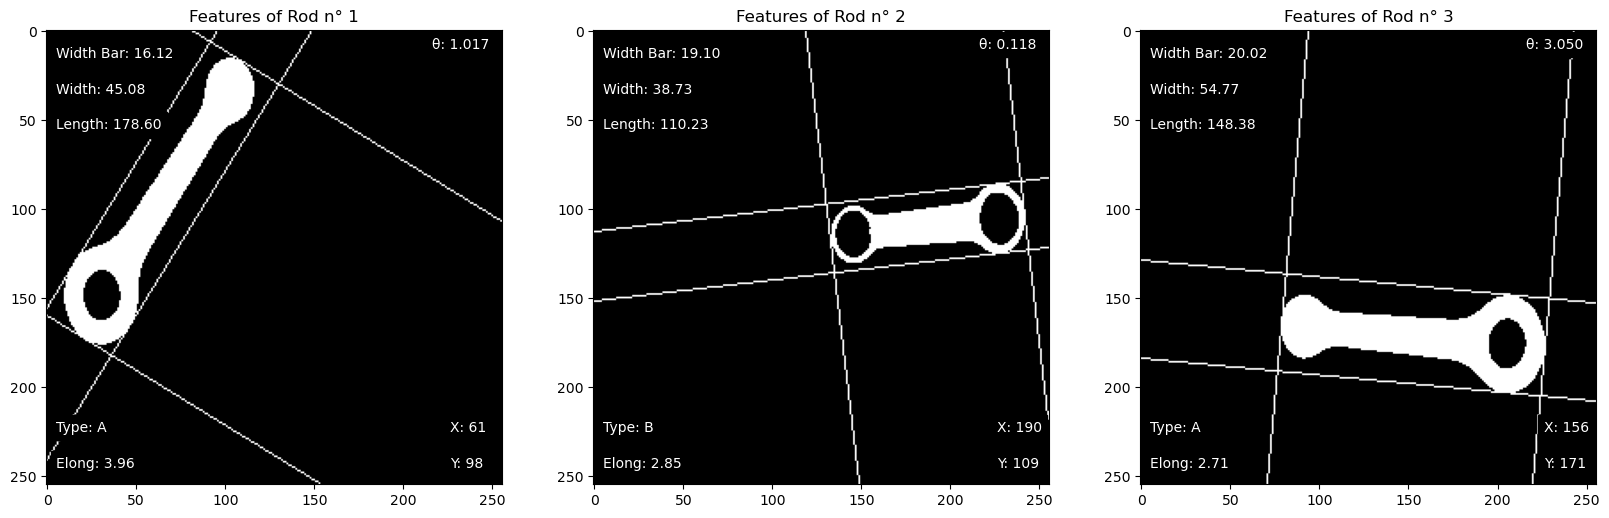

In [29]:
# Save the type and the holes present in the rod
rod_type = []
holes = []


plt.figure(figsize=(20,10))

for idx, obj in enumerate(elongated_objects):
    
    # Retrieving the parameters needed to print the final result
    box, L, W, Wb, other_params = elongated_params[idx]
    theta, B = other_params[:2]
    
    # Find the holes and save them
    holes.append(scan(255-obj))
    n_holes = len(np.unique(holes[-1]))-1       # -1 is needed to eliminate the background from the count
    
    # Define the Type of the rod: "Type A" or "Type B"
    if n_holes == 1:
        rod_type.append('A') 
    elif n_holes == 2:
        rod_type.append('B')
    else:
        rod_type.append('Error!')
    
    plt.subplot(1, max(len(elongated_objects), 3), idx+1)
    plt.imshow(white(obj+box), cmap='gray')
    plt.title(f"Features of Rod n° {idx+1}")
    plt.text(5,15, f"Width Bar: {Wb:.2f}", c="white", backgroundcolor="black")
    plt.text(5,35, f"Width: {W:.2f}", c="white", backgroundcolor="black")
    plt.text(5,55, f"Length: {L:.2f}", c="white", backgroundcolor="black")
    plt.text(5,obj.shape[0]-30, f"Type: {rod_type[-1]}", c="white", backgroundcolor="black")
    plt.text(5,obj.shape[0]-10, f"Elong: {L/W:.2f}", c="white", backgroundcolor="black")
    plt.text(obj.shape[1]-30,obj.shape[0]-30, f"X: {B[1]}", c="white", backgroundcolor="black")
    plt.text(obj.shape[1]-30,obj.shape[0]-10, f"Y: {B[0]}", c="white", backgroundcolor="black")
    plt.text(obj.shape[1]-40,10, f"θ: {(pi/2+theta)%pi:.3f}", c="white", backgroundcolor="black")
    
plt.show()

## Hole analyses

We also wanted to find the **position and diameter of the holes in each rod**.

Holes of rod 1


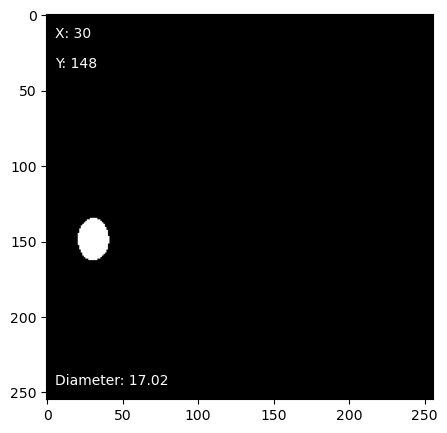

Holes of rod 2


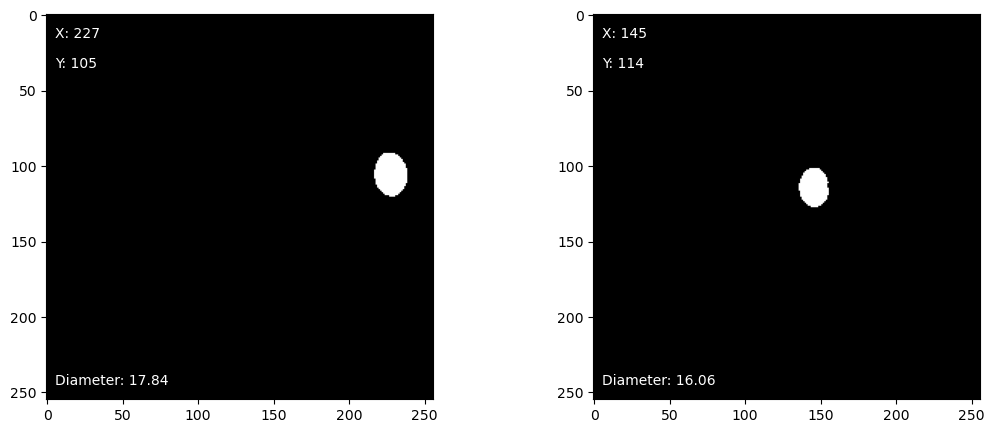

Holes of rod 3


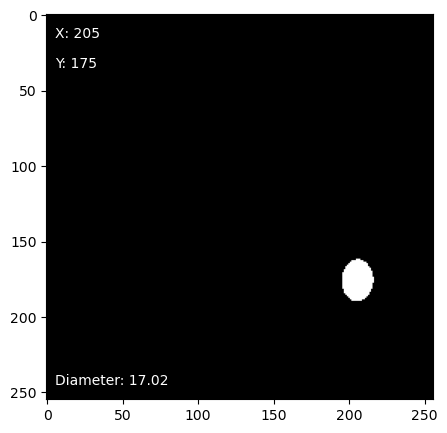

In [32]:
# For each object we will store the information about its holes
holes_obj = []

# Cycling across the holes of each object
for idx, hole in enumerate(holes):
    labels = np.unique(hole)
        
    # Save the features of the holes of each object
    hole_params = []
    
    print(f"Holes of rod {idx+1}")
    
    plt.figure(figsize=(20,5))
    
    h_idx = 0
    
    # Working separately on each hole
    for label in labels:
        h = ((hole == label) * 255).astype('uint8')
        
        # Only for labels that don't represent the background
        if np.sum(h == 255) < h.size//5: 
            
            h_idx += 1
            
            # Evaluation of Area, Diameter and Barycenter
            A = central_moment(h, 0, 0)
            d = 2*np.sqrt(A/(2*math.pi))
            B = barycenter(h)
            
            # Storing the parameters
            hole_params.append((B, d))
            
            plt.subplot(1, len(labels), h_idx+1)
            plt.imshow(h, cmap='gray', vmin=0, vmax=255)
            plt.text(5,15, f"X: {B[1]}",c="white", backgroundcolor="black")
            plt.text(5,35, f"Y: {B[0]}", c="white", backgroundcolor="black")
            plt.text(5,obj.shape[0]-10, "Diameter: "+ str(round(d, 2)), c="white", backgroundcolor="black")
    plt.show()
        
    holes_obj.append(hole_params)

## Final report

Here we **summarize all the information** we got about the rods under analyses!

In [31]:
print("Final Report:\n")

for idx in range(len(elongated_objects)):
    print("="*50)
    print("\033[1m" + f"Rod {idx+1} - Type {rod_type[idx]}\n" + "\033[0m")
    print(f"Position -> X : {elongated_params[idx][4][1][1]}, Y: {elongated_params[idx][4][1][0]}")
    print(f"Angle    -> θ : {pi/2+elongated_params[idx][4][0]:.3f}")
    print(f"Length   -> L : {elongated_params[idx][1]:.2f}")
    print(f"Width    -> W : {elongated_params[idx][2]:.2f}")
    print(f"Width B. -> Wb: {elongated_params[idx][3]:.2f}")
    for h, hole in enumerate(holes_obj[idx]):
        print(f"Hole {h+1}:")
        print(f"\tPosition -> X: {hole[0][1]}, Y: {hole[0][0]}")
        print(f"\tDiameter -> d: {hole[1]:.2f}")
    
print("="*50)

Final Report:

Rod 1 - Type A

Position -> X : 61, Y: 98
Angle    -> θ : 1.017
Length   -> L : 178.60
Width    -> W : 45.08
Width B. -> Wb: 16.12
Hole 1:
	Position -> X: 30, Y: 148
	Diameter -> d: 17.02
Rod 2 - Type B

Position -> X : 190, Y: 109
Angle    -> θ : 3.260
Length   -> L : 110.23
Width    -> W : 38.73
Width B. -> Wb: 19.10
Hole 1:
	Position -> X: 227, Y: 105
	Diameter -> d: 17.84
Hole 2:
	Position -> X: 145, Y: 114
	Diameter -> d: 16.06
Rod 3 - Type A

Position -> X : 156, Y: 171
Angle    -> θ : 3.050
Length   -> L : 148.38
Width    -> W : 54.77
Width B. -> Wb: 20.02
Hole 1:
	Position -> X: 205, Y: 175
	Diameter -> d: 17.02
